In [1]:
import pandas as pd
import numpy as np

from datetime import datetime

import matplotlib.pyplot as plt
import networkx as nx


import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from gensim.parsing.preprocessing import STOPWORDS
import pprint
import nltk
from nrclex import NRCLex
import re

from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import PorterStemmer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from collections import OrderedDict
from operator import itemgetter

%matplotlib inline
from matplotlib import pyplot as plt
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

from nltk.sentiment import SentimentIntensityAnalyzer

import sys
import warnings
if not sys.warnoptions: warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
def text_process(t): 
    if isinstance(t, str): 
        t = t.lower()
        t = re.sub(r'[0-9]', '', t) 
        t = re.sub('[,\.!?/#!@$%^&*:_]', ' ', t) 
        t = t.strip() 
        return t 
    else: return "" 

def isEnglish(s): 
        try: s.encode(encoding='utf-8').decode('ascii')
        except UnicodeDecodeError: return False
        else: return True
    
def compute_coherence_values(dictionary, corpus, texts, limit=10, start=2, step=1):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=42)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

def get_textlist(df):
    df = df.dropna()
    df['language'] = df['clean_data'].apply(lambda x: isEnglish(x))
    df = df[df['language'] == True]
    df = df.drop(columns=['language'])
    df = df.drop_duplicates(subset=['clean_data'])

    text_list = df['clean_data'].to_list()
    return df, text_list

def get_arguments(text_list, remove_list):
    texts = [[word for word in text.lower().split() 
              if word not in STOPWORDS and word.isalnum() and not word.isdigit() and word not in remove_list] 
             for text in text_list]

    dictionary = corpora.Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]
    return texts, dictionary, corpus

def get_score_graph(start=5, limit=15, step=2):
    model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=texts, 
                                                            start=start, limit=limit, step=step)
    # Show graph
    limit=limit; start=start; step=step;
    x = range(start, limit, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()
    
def lda_graph(n):
    lda = LdaModel(corpus, id2word=dictionary, num_topics=n, passes=15, random_state=42)
    pyLDAvis.enable_notebook()
    vis = gensimvis.prepare(lda, corpus, dictionary)
    return lda, vis

def get_topic(df):
    
    def topic(corpus):
        topic_list = []
        for i in range(len(corpus)):
            topic = sorted(lda.get_document_topics(corpus[i], minimum_probability=0, per_word_topics=False), key=itemgetter(1), reverse=True)[0][0]
            topic_list.append(topic)
        return topic_list
    
    df['topic'] = topic(corpus)
    
    def get_words(topic): return [i[0] for i in lda.show_topic(topic, topn=20)]
    df['topic_words'] = df['topic'].apply(lambda x: get_words(x))
    return df

def sentimental_analysis(df, col):
    def score(t):
        text_object = NRCLex(t)
        score_list = text_object.top_emotions

        def Convert(tup, di): return dict(tup)
        
        dictionary = {}
        di = Convert(score_list, dictionary)
        return di
    
    df['sentimental_raw'] = df[col].apply(lambda x: score(x))
    
    def one_hot(df, senti):
        df[senti] = df['sentimental_raw'].apply(lambda x: x.get(senti) if (senti in x.keys()) else 0.0)
        return df
    
    sent_list = ['fear','anger','anticip','trust','surprise','positive','negative','sadness','disgust','joy']
    for s in sent_list: df = one_hot(df,s)
    
    return df

def get_nyt(nyt):
    nyt = pd.read_csv('DIS_NYT.csv')
    nyt['clean_data'] = nyt['abstract'].apply(lambda x: text_process(x))
    nyt = nyt.rename(columns={"pub_date": "date"})
    nyt['source'] = 'New York Times'
    nyt = nyt[['date', 'source', 'clean_data']]
    return nyt

In [3]:
final_df = pd.read_csv('/Users/emma/Desktop/MS Data Challenge/dis_news.csv')
final_df

,Unnamed: 0,date,source,clean_data
0,0,2010/01/04,CNBC,retail signs of the times
1,1,2010/01/04,CNBC,next up on cable tv higher bill for consumers
2,2,2010/01/04,CNBC,trying to add portability to movie files
3,3,2010/01/05,CNBC,the mad rush for -d tv
4,4,2010/01/05,CNBC,disney's plan to unlock digital revenues
...,...,...,...,...
18560,18560,2020/12/31,New York Times,business entertainment news activism and so...
18561,18561,2020/12/31,New York Times,NaN
18562,18562,2020/12/31,New York Times,david j kahn escorts the old year to the door
18563,18563,2020/12/31,New York Times,nicolas cage hosts the history of swearing lo...


In [4]:
df, text_list = get_textlist(final_df)
remove_list = ['disney','walt','says','said','say','stock','s','p','u','m','q','th','vs','j','n','b','t','d','g','c','e','o','f','k','l','v']
texts, dictionary, corpus = get_arguments(text_list, remove_list)

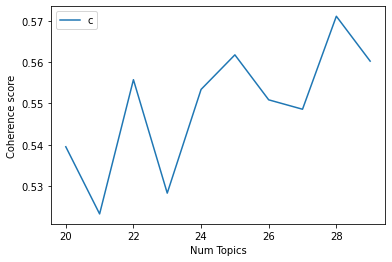

In [5]:
get_score_graph(start=20, limit=30, step=1)

In [6]:
lda, vis = lda_graph(28)
lda.print_topics()

[(17,
  '0.116*"media" + 0.057*"investors" + 0.056*"companies" + 0.049*"market" + 0.042*"news" + 0.025*"verizon" + 0.025*"big" + 0.022*"social" + 0.019*"thursday" + 0.018*"buying"'),
 (9,
  '0.063*"fox" + 0.049*"sports" + 0.043*"hit" + 0.037*"services" + 0.032*"months" + 0.029*"plans" + 0.027*"florida" + 0.026*"coming" + 0.022*"networks" + 0.017*"james"'),
 (26,
  '0.084*"deal" + 0.075*"company" + 0.052*"billion" + 0.030*"president" + 0.026*"fox" + 0.019*"group" + 0.018*"david" + 0.017*"sees" + 0.016*"online" + 0.014*"technology"'),
 (15,
  '0.044*"hollywood" + 0.034*"way" + 0.029*"books" + 0.028*"workers" + 0.021*"black" + 0.020*"virtual" + 0.018*"life" + 0.017*"picture" + 0.017*"raises" + 0.017*"push"'),
 (7,
  '0.034*"picks" + 0.033*"hits" + 0.033*"high" + 0.032*"price" + 0.022*"power" + 0.019*"case" + 0.017*"value" + 0.017*"era" + 0.017*"debut" + 0.016*"rules"'),
 (14,
  '0.080*"day" + 0.052*"big" + 0.041*"office" + 0.040*"box" + 0.040*"season" + 0.025*"trades" + 0.024*"launch" + 0

In [7]:
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
23    -0.323200  0.119337       1        1  6.807123
10    -0.034413 -0.275201       2        1  4.876253
16    -0.094000 -0.321099       3        1  4.840194
2      0.064325 -0.005804       4        1  4.362309
26     0.074915  0.024915       5        1  4.305104
1     -0.141081 -0.024587       6        1  4.049001
17    -0.050085  0.024866       7        1  3.868496
22    -0.009432  0.030805       8        1  3.859761
14    -0.040784  0.030661       9        1  3.833903
18     0.049582 -0.031527      10        1  3.707150
25     0.005797  0.026199      11        1  3.609846
0     -0.204115  0.100143      12        1  3.582321
24    -0.064382 -0.012967      13        1  3.551085
21     0.055003  0.045656      14        1  3.512080
15     0.038729  0.036301      15        1  3.394903
9      0.054132  0.015225      16        1  3.383310
27     0.060564 -0.005492      17        1  3.245161
19     0.017405  0.010299      18        1  3.210396
8      0.017054  0.049952      19        1  3.156118
5      0.018548 -0.044119      20        1  3.127449
7      0.052605  0.024939      21        1  3.112885
13     0.062105  0.033609      22        1  2.888553
3      0.065729  0.016278      23        1  2.813874
12     0.075048  0.033226      24        1  2.787263
6      0.048417  0.023039      25        1  2.747216
4      0.062862  0.035993      26        1  2.599365
11     0.072778  0.029409      27        1  2.471326
20     0.065894  0.009943      28        1  2.297555, topic_info=           Term         Freq        Total Category  logprob  loglift
394         new  1193.000000  1193.000000  Default  30.0000  30.0000
44       stocks   912.000000   912.000000  Default  29.0000  29.0000
817     biggest   528.000000   528.000000  Default  28.0000  28.0000
113   streaming   576.000000   576.000000  Default  27.0000  27.0000
271         ceo   424.000000   424.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
2475       host    14.019533    15.088931  Topic28  -5.0521   3.6998
112       shows   191.478084   239.009898  Topic28  -2.4377   3.5516
155   universal    32.412886    36.598034  Topic28  -4.2140   3.6519
1725   articles    15.243241    17.776127  Topic28  -4.9684   3.6196
943         bad    17.811867    29.064402  Topic28  -4.8126   3.2837

[1068 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
5010     10  0.966926       aapl
305      16  0.985627        abc
2398      4  0.278657  according
2398     22  0.696642  according
1848      5  0.971395    accused
...     ...       ...        ...
304      18  0.163404      years
320       3  0.966153        yes
1285      2  0.996770       york
995      14  0.981990      young
130      14  0.989715    youtube

[1186 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[24, 11, 17, 3, 27, 2, 18, 23, 15, 19, 26, 1, 25, 22, 16, 10, 28, 20, 9, 6, 8, 14, 4, 13, 7, 5, 12, 21])

In [8]:
df = get_topic(df)
sia = SentimentIntensityAnalyzer()
df['compound_sent'] = df.apply(lambda x: sia.polarity_scores(x.clean_data)['compound'], axis=1)
df

,Unnamed: 0,date,source,clean_data,topic,topic_words,compound_sent
0,0,2010/01/04,CNBC,retail signs of the times,10,"[new, york, street, wall, city, theater, inclu...",0.0000
1,1,2010/01/04,CNBC,next up on cable tv higher bill for consumers,18,"[time, money, comcast, content, warner, midday...",0.0000
2,2,2010/01/04,CNBC,trying to add portability to movie files,2,"[theaters, states, movie, sales, million, unit...",0.0000
3,3,2010/01/05,CNBC,the mad rush for -d tv,16,"[streaming, making, new, tv, service, movies, ...",-0.4939
4,4,2010/01/05,CNBC,disney's plan to unlock digital revenues,21,"[parks, game, players, plan, entertainment, st...",0.0000
...,...,...,...,...,...,...,...
18559,18559,2020/12/31,New York Times,we talked to the broadway stars behind a virtu...,25,"[cramer, buy, apple, wars, star, free, july, s...",0.5267
18560,18560,2020/12/31,New York Times,business entertainment news activism and so...,17,"[media, investors, companies, market, news, ve...",0.4215
18562,18562,2020/12/31,New York Times,david j kahn escorts the old year to the door,26,"[deal, company, billion, president, fox, group...",0.0000
18563,18563,2020/12/31,New York Times,nicolas cage hosts the history of swearing lo...,13,"[million, record, john, rises, better, expecta...",0.2263


In [9]:
# df.to_csv('dis_news_.csv')